# **前日の20:00までの気象予報データを用いて翌日の00:00~23:30までの発電量を弱学習機で予測する**

### **必要な関数・ライブラリ**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import MLP

%matplotlib inline

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [4]:
def add_hour_month(input_data):
    '''
    時間や月のデータを加える
    '''
    input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
    input_data['minute'] = input_data['datetime'].map(lambda x: int(x.minute))
    input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data = input_data.drop(['hour', 'minute', 'month'], axis=1)
    return input_data

In [5]:
def get_30(tmp_data):
    '''
    必要なカラムだけ拾ってきて30分ごのデータに整形
    '''
    tmp_data = tmp_data[["datetime", "pr", "max_ws", "ave_ws", "max_tp", "min_tp", "sl"]]
    
    # 欠損値を一つ前の値で置換/output_data
    tmp_data = tmp_data.fillna(method='bfill')
    tmp_30 = tmp_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

    # datetimeのカラムを復活させる
    tmp_30['datetime'] = tmp_30.index
    tmp_30.index = np.arange(len(tmp_30))
    tmp_30.head()
    return tmp_30

In [6]:
def add_time_sincos(input_data):
    '''
    datetimeカラムがあることを前提に月時分の三角関数を足す
    '''
    input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
    input_data['minute'] = input_data['datetime'].map(lambda x: int(x.minute))
    input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data['min_cos'] = input_data['minute'].map(lambda x: np.cos(np.pi * x / 60))
    input_data['min_sin'] = input_data['minute'].map(lambda x: np.sin(np.pi * x / 60))
    input_data = input_data.drop(['hour', 'minute', 'month'], axis=1)
    return input_data

In [7]:
def normalize_array(x):
    '''
    min, max, min-max正規化を行なった配列(np.array)を返す
    '''
    x = np.array(x)
    x_min = x.min()
    x_max = x.max()
    normalized = (x - x_min) / (x_max - x_min) 
    return x_min, x_max, normalized

In [8]:
def denormalize_array(normalized_x, x_min, x_max):
    '''
    正規化前のmin, maxを用いて元のスケールに戻す
    '''
    normalized_x = np.array(normalized_x)
    denormalize_array = (normalized_x) * (x_max - x_min) + x_min
    return denormalize_array

In [184]:
def drop_nan(X, Y):
    '''
    正解データがnanであるデータの組を削除
    '''
    mask = np.isnan(Y)
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

In [12]:
def calc_mae(X, Y):
    '''
    X, Yがメモリを食いすぎるのでfor文で計算
    '''
    mse = 0
    for i in range(len(X)):
        mse += np.abs(X[i]- Y[i])
    return mse/len(X)

### **データの準備**

In [152]:
target_place = 1

In [153]:
# 発電量データ
output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
output_30['datetime'] = output_30['datetime'].map(lambda x : pd.to_datetime(x))
output_30 = output_30[['datetime', 'SOLA0'+str(target_place)]]

In [154]:
# 天気予報のデータを実は今まで使ってなかった
if target_place == 1 or target_place == 2:
    fc_data = pd.read_csv('data/raw_data/forecast_kanagawa.tsv', delimiter = '\t')
    fc_data['date'] = fc_data['date'].map(lambda x : pd.to_datetime(x))
elif target_place == 3:
    fc_data = pd.read_csv('data/raw_data/forecast_yamanashi.tsv', delimiter = '\t')
    fc_data['date'] = fc_data['date'].map(lambda x : pd.to_datetime(x))
else:
    raise ValueError("invalid input target_place")

In [155]:
# 各降水確率, 各時間帯の天気, 気温のみを選択
fc_data = fc_data.drop(['weather', 'weather_detail', 'wind', 'wave', 'wv_00-03',
       'wv_03-06', 'wv_06-09', 'wv_09-12', 'wv_12-15', 'wv_15-18', 'wv_18-21',
       'wv_21-24', 'wc_00-03', 'wc_03-06', 'wc_06-09', 'wc_09-12', 'wc_12-15',
       'wc_15-18', 'wc_18-21', 'wc_21-24'], axis=1)

In [156]:
hours = ['we_00-03', 'we_03-06', 'we_06-09', 'we_09-12', 'we_12-15', 'we_15-18', 'we_18-21', 'we_21-24']
for hour in hours:
    dummy_df = pd.get_dummies(fc_data[[hour]])
    fc_data = pd.concat([fc_data, dummy_df], axis=1, join='inner')
    fc_data= fc_data.drop([hour], axis=1)

In [167]:
if target_place == 1 or target_place == 2:
    try:
        wfc_data = pd.read_csv('data/processed_data/wfc_yokohama_30', delimiter='\t')
        wfc_data['datetime'] =  wfc_data['datetime'].map(lambda x : pd.to_datetime(x))
        
    except FileNotFoundError:
        # input_dataを作る
        target_amd_data = pd.read_csv('data/raw_data/amd_46106.tsv', delimiter = '\t')
        target_amd_data = set_time(target_amd_data, 'datetime')
        target_amd_data['datetime'] = target_amd_data['datetime'].map(lambda x : pd.to_datetime(x))
        target_amd_data = get_30(target_amd_data)
        # 時間の情報
        input_hours = target_amd_data[['datetime']]
        input_hours = add_time_sincos(input_hours)
        array = np.array(fc_data.drop(["date"], axis=1))
        print("-- making input_data wfc_yokohama_30 @ data/processed_data/--")
        wfc_data = np.array([])
        # 各時間帯に天気予報の情報を複製ながらはめていく
        for i in range(len(array)):
            for i in range(48):
                wfc_data = np.append(wfc_data, array[i])
        # dfにして保存
        tmp = wfc_data.reshape(int(len(wfc_data)/len(array[0])), len(array[0]))
        fc_df = pd.DataFrame(tmp)
        fc_df.columns = fc_data.columns[1:47]
        # 時間の情報と合体
        wfc_data = pd.concat([input_hours, fc_df], axis=1, join='inner')
        wfc_data.to_csv('data/processed_data/wfc_yokohama_30', sep = '\t', index=False)

elif target_place == 3:
    try:
        wfc_data = pd.read_csv('data/processed_data/wfc_yamanashi_30', delimiter='\t')
        wfc_data['datetime'] = wfc_data['datetime'].map(lambda x : pd.to_datetime(x))
        
    except FileNotFoundError:
        # input_dataを作る
        target_amd_data = pd.read_csv('data/raw_data/amd_49142.tsv', delimiter = '\t')
        target_amd_data = set_time(target_amd_data, 'datetime')
        target_amd_data['datetime'] = target_amd_data['datetime'].map(lambda x : pd.to_datetime(x))
        target_amd_data = get_30(target_amd_data)
        # 時間の情報
        input_hours = target_amd_data[['datetime']]
        input_hours = add_time_sincos(input_hours)
        array = np.array(fc_data.drop(["date"], axis=1))
        print("-- making input_data wfc_yamanashi_30 @ data/processed_data/--")
        wfc_data = np.array([])
        # 各時間帯に天気予報の情報を複製ながらはめていく
        for i in range(len(array)):
            for i in range(48):
                wfc_data = np.append(wfc_data, array[i])
        # dfにして保存
        tmp = wfc_data.reshape(int(len(wfc_data)/len(array[0])), len(array[0]))
        fc_df = pd.DataFrame(tmp)
        fc_df.columns = fc_data.columns[1:47]
        # 時間の情報と合体
        wfc_data = pd.concat([input_hours, fc_df], axis=1, join='inner')
        wfc_data.to_csv('data/processed_data/wfc_yamanashi_30', sep = '\t', index=False)

In [168]:
wfc_data.head()

,datetime,month_cos,month_sin,hour_cos,hour_sin,min_cos,min_sin,pc_00-06,pc_06-12,pc_12-18,...,we_15-18_雨,we_15-18_雪,we_18-21_くもり,we_18-21_晴れ,we_18-21_雨,we_18-21_雪,we_21-24_くもり,we_21-24_晴れ,we_21-24_雨,we_21-24_雪
0,2012-01-01 00:00:00,0.965926,0.258819,1.000000,0.000000,1.000000e+00,0.0,30.0,30.0,10.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2012-01-01 00:30:00,0.965926,0.258819,1.000000,0.000000,2.832769e-16,1.0,20.0,20.0,10.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2012-01-01 01:00:00,0.965926,0.258819,0.991445,0.130526,1.000000e+00,0.0,0.0,0.0,10.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2012-01-01 01:30:00,0.965926,0.258819,0.991445,0.130526,2.832769e-16,1.0,10.0,10.0,30.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2012-01-01 02:00:00,0.965926,0.258819,0.965926,0.258819,1.000000e+00,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [185]:
# モデル構築のためにデータを分割する

# 学習に必要なデータ
# 前日の気象予報のデータで翌日の0:00 ~ 23:30を予測する
train_x_s_idx = wfc_data[wfc_data['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_x_e_idx = wfc_data[wfc_data['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]
train_y_s_idx = output_30[output_30['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_y_e_idx = output_30[output_30['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

output_kwh = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
input_data = wfc_data.drop(["datetime"], axis=1)[train_x_s_idx:train_x_e_idx+1]

# 予測に必要なデータ
# 前日の00:00 ~ 20:00のデータで翌日の0:00 ~ 23:30を予測する
test_x_s_idx = wfc_data[wfc_data["datetime"] == pd.to_datetime('2016-01-01 00:00')].index[0]
test_x_e_idx = wfc_data[wfc_data["datetime"] == pd.to_datetime('2017-3-31 23:30')].index[0]

test_input_data = wfc_data.drop(["datetime"], axis=1)[test_x_s_idx:test_x_e_idx+1]

### **線形回帰**

In [242]:
from sklearn import linear_model

In [227]:
# min-max正規化しておく
normalized_input = (input_data - input_data.min()) / (input_data.max() - input_data.min())
normalized_input = normalized_input.dropna(axis=1)
normalized_input = np.array(normalized_input)
normalized_kwh = (output_kwh - output_kwh.min()) /( output_kwh.max() - output_kwh.min())
normalized_kwh = np.array(normalized_kwh)

input_list = normalized_input
kwh_list =normalized_kwh

X, Y = drop_nan(input_list, kwh_list)

# testデータの入力を用意
normalized_test_input = (test_input_data - test_input_data.min()) / (test_input_data.max() - test_input_data.min())
normalized_test_input = normalized_test_input.dropna(axis=1)
normalized_test_input = np.array(normalized_test_input)

X_test = normalized_test_input

# denormalize用
kwh_max = float(output_kwh.max())
kwh_min = float(output_kwh.min())

In [228]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

In [229]:
lin_model = linear_model.LinearRegression()
lin_model.fit(X_train, Y_train)

Y_train_pred = lin_model.predict(X_train)
Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

Y_val_pred = lin_model.predict(X_val)
Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)

print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
print("test_mae : ", np.abs(Y_val_pred - Y_val_true).mean())

train_mae :  368.519272437
test_mae :  368.89336958


In [231]:
Y_test_pred = lin_model.predict(X_test)
Y_test_pred = denormalize_array(Y_test_pred, kwh_min, kwh_max)

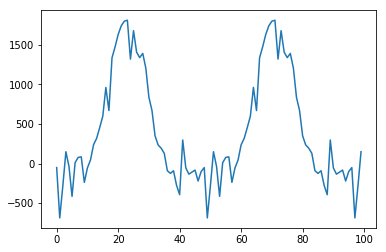

In [234]:
plt.plot(Y_test_pred[0:100])

### **random forest**

In [241]:
from sklearn.ensemble import RandomForestRegressor

In [236]:
input_list = np.array(input_data)
kwh_list = np.array(output_kwh)

X, Y = drop_nan(input_list, kwh_list)

# testデータの入力を用意
X_test = np.array(test_input_data)

In [238]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

In [239]:
n_estimators = 20
max_depth = 4
max_features = "sqrt"

In [243]:
rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, max_features=max_features)
rf.fit(X_train, Y_train)
Y_train_pred = rf.predict(X_train)
Y_val_pred = rf.predict(X_val)
print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

train_mae :  345.177661175
val_mae :  347.540147257


In [244]:
Y_test_pred = rf.predict(X_test)

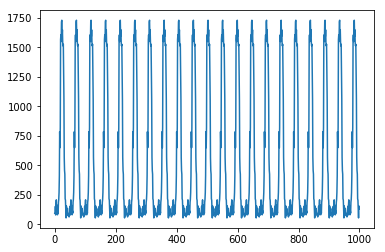

In [246]:
plt.plot(Y_test_pred[0:1000])